In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr
import numpy as np

In [11]:
dados_resultados = pd.read_csv("DADOS/resultados.csv", sep=";", encoding="latin1")

In [12]:
dados_resultados = dados_resultados.drop(['NU_SEQUENCIAL', 'NU_ANO', 'CO_ESCOLA', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA',
       'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'CO_MUNICIPIO_ESC', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT','TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH',
       'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT','TP_LINGUA', 'TP_STATUS_REDACAO','TX_GABARITO_CN', 'TX_GABARITO_CH','TX_GABARITO_LC', 'TX_GABARITO_MT'], axis=1)


In [15]:
dados_resultados = dados_resultados.dropna()


In [17]:
dados_resultados = dados_resultados.rename(columns={"SG_UF_PROVA" : "Estado"})

In [42]:
def criar_mapa(col_name : str):
    materia = ''
    if col_name == "NU_NOTA_REDACAO":
        materia = "Redação"
    if col_name == "NU_NOTA_MT":
        materia = "Matemática e suas Tecnologias"
    if col_name == "NU_NOTA_LC":
        materia = "Linguagens e Códigos"
    if col_name == "NU_NOTA_CH":
        materia = "Ciências Humanas"
    if col_name == "NU_NOTA_CN":
        materia = "Ciências da Natureza"


    dados_resultados[col_name] = pd.to_numeric(dados_resultados[col_name], errors='coerce')

    # (opcional) tratar zeros como ausentes
    # df.loc[df['NU_NOTA_REDACAO'] <= 0, 'NU_NOTA_REDACAO'] = np.nan

    # média por UF
    media_uf = (dados_resultados.dropna(subset=['Estado',col_name])
                .groupby('Estado', as_index=False)[col_name]
                .mean()
                .rename(columns={col_name:'nota_media_uf'}))

    # geometrias dos estados
    gdf_uf = geobr.read_state(year=2020, simplified=True)[['abbrev_state', 'geometry']]
    gdf_uf = gdf_uf.rename(columns={'abbrev_state':'Estado'})

    # juntar e mapear
    mapa = gdf_uf.merge(media_uf, on='Estado', how='left')

    fig, ax = plt.subplots(figsize=(9, 10))
    mapa.plot(
        column='nota_media_uf',
        ax=ax,
        legend=True,
        legend_kwds={'label': f'Nota média {materia}'},
        edgecolor='white',
        linewidth=0.6,
        # mostrar visualmente estados sem dados
        missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'Sem dados'}
    )
    ax.set_title(f'Nota média de {materia} por estado (ENEM)', pad=12)
    ax.axis('off')

    # siglas no centroide representativo
    rep_pts = mapa.geometry.representative_point()
    for x, y, label in zip(rep_pts.x, rep_pts.y, mapa['Estado']):
        ax.text(x, y, label, ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'mapa_media_enem_{materia}_por_estado.png', dpi=300, bbox_inches='tight')

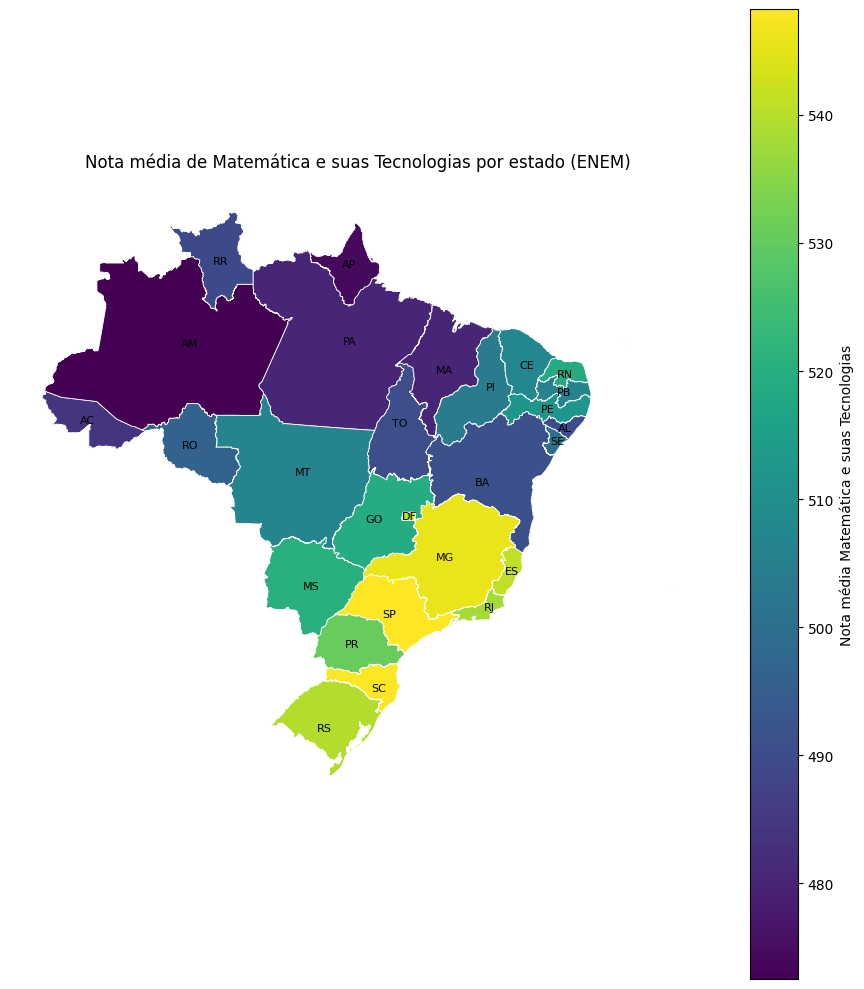

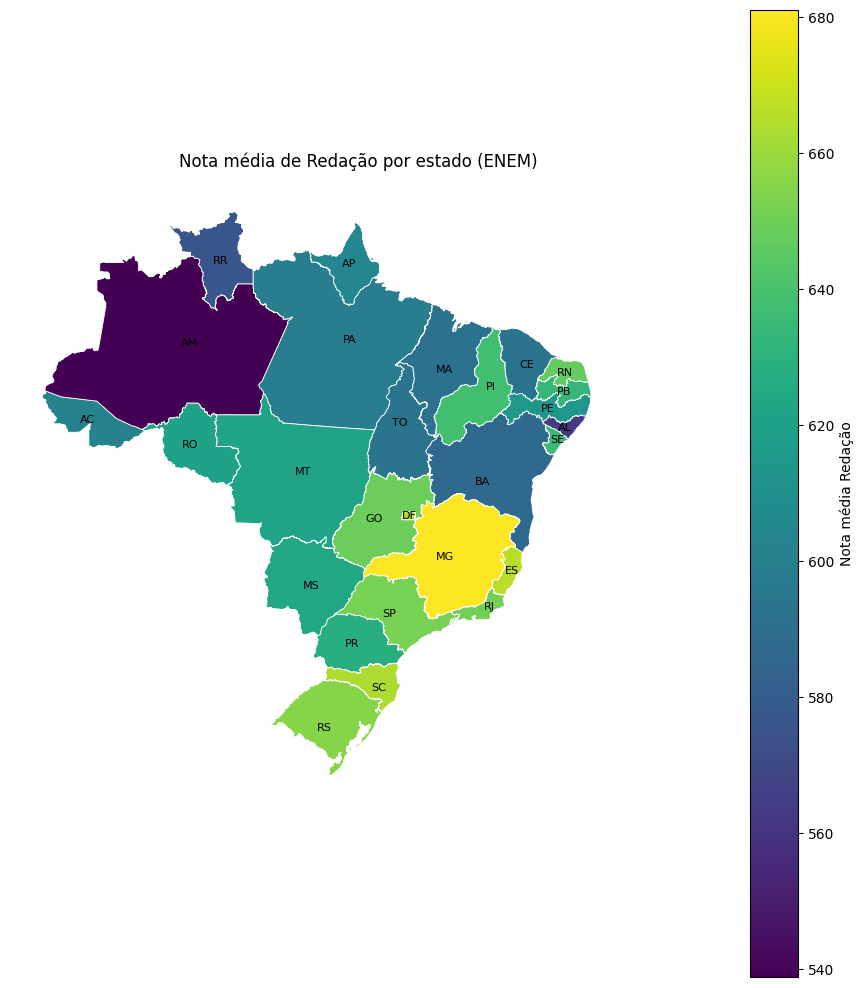

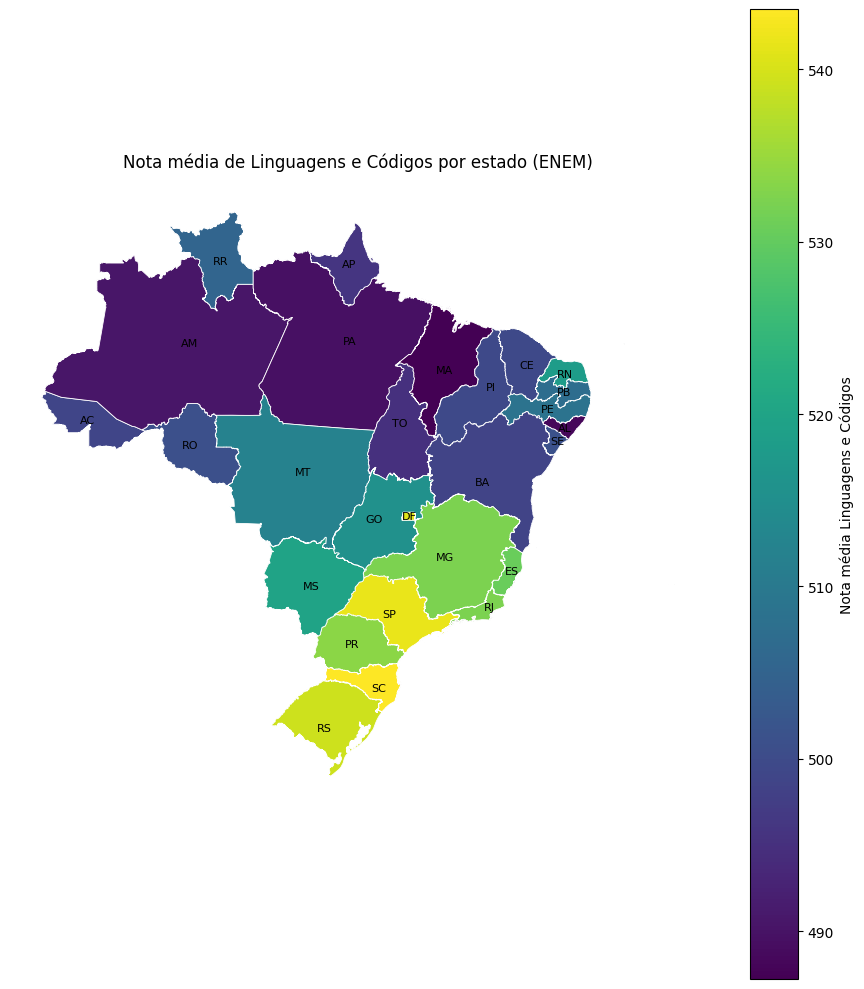

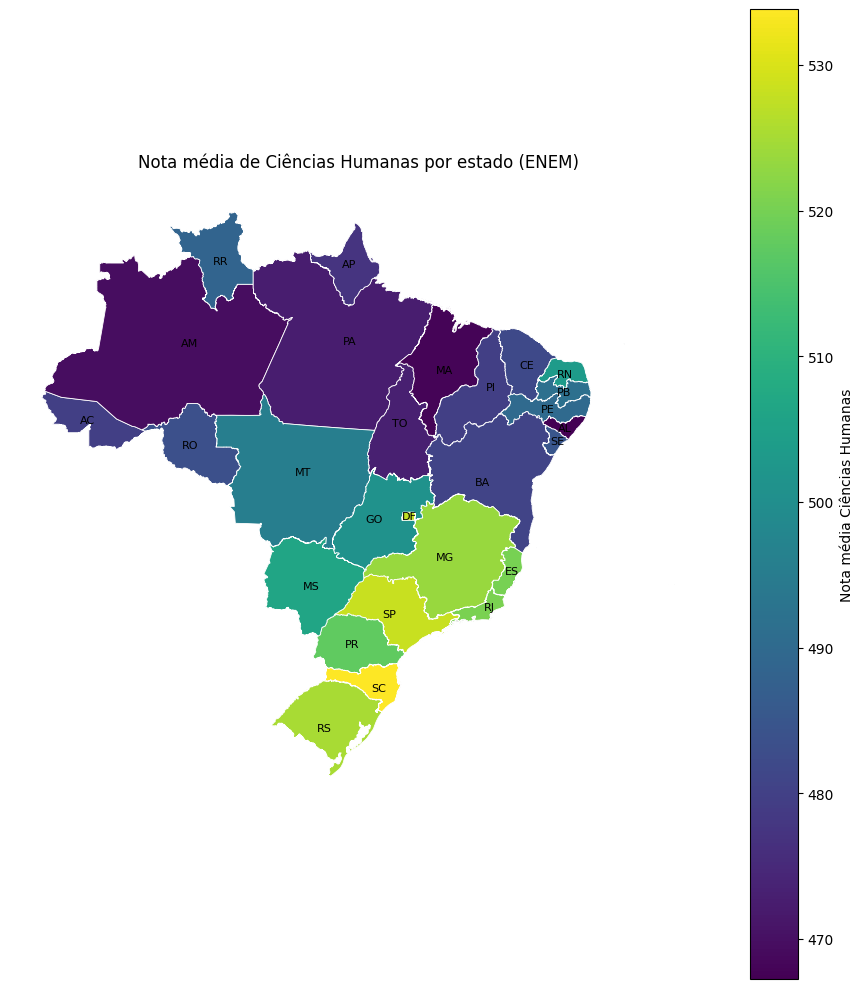

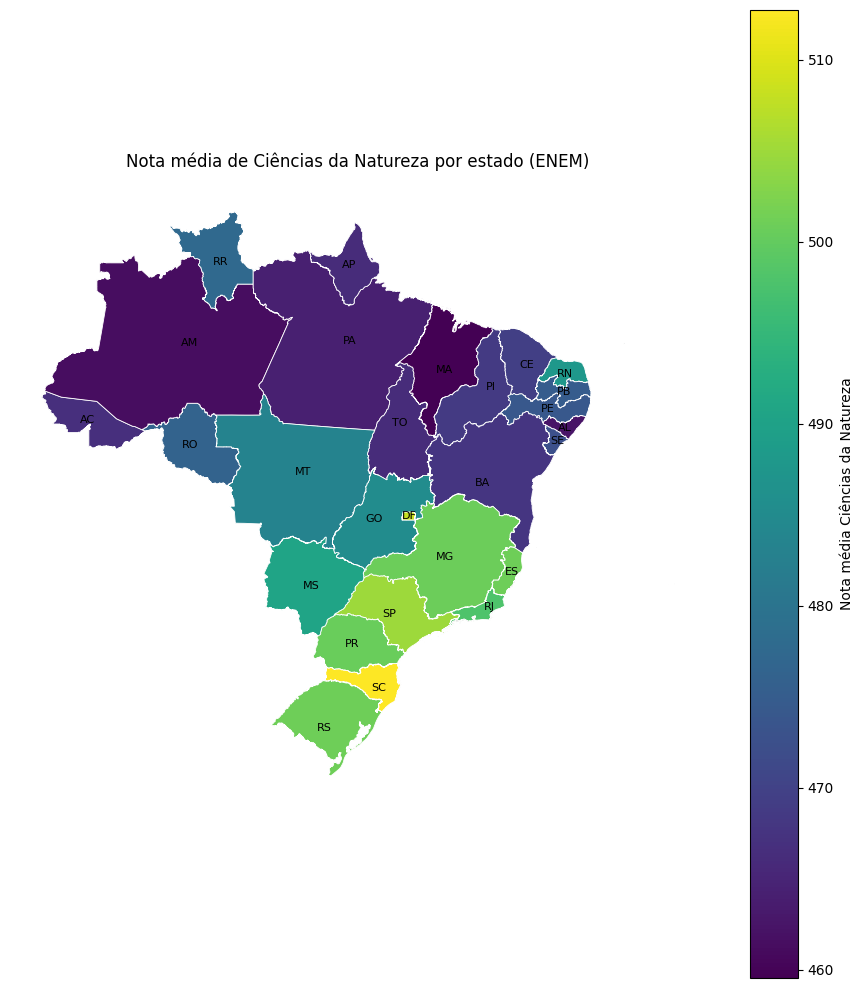

In [43]:
cols_notas = ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']

for c in cols_notas:
    criar_mapa(c)

In [41]:
# 1) Calcular a média das 5 notas por aluno
dados_resultados["nota_media"] = dados_resultados[
    ["NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_REDACAO"]
].mean(axis=1)

# 2) Agrupar por cidade e calcular a média geral por cidade
media_por_cidade = (
    dados_resultados.groupby("NO_MUNICIPIO_ESC", as_index=False)["nota_media"]
    .mean()
    .rename(columns={"nota_media": "media_cidade"})
)

# 3) Ordenar do maior para o menor
top_dez_cidades = media_por_cidade.sort_values(by="media_cidade", ascending=False).head(10)

# 4) Mostrar resultado
top_dez_cidades


,NO_MUNICIPIO_ESC,media_cidade
618,Bom Jesus do Oeste,652.856000
4226,Santa Tereza,644.360000
5281,Álvaro de Carvalho,635.660000
3805,Presidente Lucena,632.800000
1176,Cocal dos Alves,631.833846
2081,Inúbia Paulista,622.170000
208,Anta Gorda,620.391724
5150,Veranópolis,617.514021
1935,Holambra,613.376667
4944,Timóteo,611.544516
